In [24]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import importlib
import numpy as np
import tensorflow as tf
import texar as tx

#from RL_model import RLModel

In [25]:
import tensorflow as tf

import texar as tx
from texar.modules import WordEmbedder, UnidirectionalRNNEncoder, \
        MLPTransformConnector, AttentionRNNDecoder, \
        GumbelSoftmaxEmbeddingHelper, Conv1DClassifier
from texar.core import get_train_op
from texar.utils import collect_trainable_variables, get_batch_size


class RLModel(object):
    """Control
    """

    def __init__(self, inputs, vocab,hparams=None):
        self._hparams = tx.HParams(hparams, None)
        self._build_model(inputs, vocab)

    def _build_model(self, inputs, vocab):
        """Builds the model.
        """
        embedder = WordEmbedder(
            vocab_size=vocab.size,
            hparams=self._hparams.embedder)
        encoder = UnidirectionalRNNEncoder(hparams=self._hparams.encoder)

        # text_ids for encoder, with BOS token removed
        enc_text_ids = inputs['text_ids'][:, 1:]
        enc_outputs, final_state = encoder(embedder(enc_text_ids),
                                           sequence_length=inputs['length']-1)
        #z = final_state[:, self._hparams.dim_c:]
        z = final_state
        h = z
        
        # Encodes label
        #label_connector = MLPTransformConnector(self._hparams.dim_c)

        # Gets the sentence representation: h = (c, z)
        #labels = tf.to_float(tf.reshape(inputs['labels'], [-1, 1]))
        #c = label_connector(labels)
        #c_ = label_connector(1 - labels) #相反style的label向量
        #h = tf.concat([c, z], 1) #训练ae时候用的reconstructed latent vector
        #h_ = tf.concat([c_, z], 1) #训练style transfer时候用的latent vector
        
        
        # Teacher-force decoding and the auto-encoding loss for G
        decoder = AttentionRNNDecoder(
            memory=enc_outputs,
            memory_sequence_length=inputs['length']-1,
            cell_input_fn=lambda inputs, attention: inputs,
            vocab_size=vocab.size,
            hparams=self._hparams.decoder)

        connector = MLPTransformConnector(decoder.state_size)

        g_outputs, _, _ = decoder(
            initial_state=connector(h), inputs=inputs['text_ids'],
            embedding=embedder, sequence_length=inputs['length']-1)

        loss_g_ae = tx.losses.sequence_sparse_softmax_cross_entropy(
            labels=inputs['text_ids'][:, 1:],
            logits=g_outputs.logits,
            sequence_length=inputs['length']-1,
            average_across_timesteps=True,
            sum_over_timesteps=False)
        
        
        '''
        # Gumbel-softmax decoding, used in training
        start_tokens = tf.ones_like(inputs['labels']) * vocab.bos_token_id
        end_token = vocab.eos_token_id
        gumbel_helper = GumbelSoftmaxEmbeddingHelper(
            embedder.embedding, start_tokens, end_token, gamma)

        soft_outputs_, _, soft_length_, = decoder(
            helper=gumbel_helper, initial_state=connector(h_))
        '''
        
        # Greedy decoding, used in eval
        start_tokens = tf.ones_like(inputs['labels']) * vocab.bos_token_id
        end_token = vocab.eos_token_id
        outputs, _, length = decoder(
            decoding_strategy='infer_greedy', initial_state=connector(h),
            embedding=embedder, start_tokens=start_tokens, end_token=end_token)
        
        
        '''
        # Creates classifier
        classifier = Conv1DClassifier(hparams=self._hparams.classifier)
        clas_embedder = WordEmbedder(vocab_size=vocab.size,
                                     hparams=self._hparams.embedder)

        # Classification loss for the classifier
        clas_logits, clas_preds = classifier(
            inputs=clas_embedder(ids=inputs['text_ids'][:, 1:]),
            sequence_length=inputs['length']-1)
        loss_d_clas = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.to_float(inputs['labels']), logits=clas_logits)
        loss_d_clas = tf.reduce_mean(loss_d_clas)
        accu_d = tx.evals.accuracy(labels=inputs['labels'], preds=clas_preds)

        # Classification loss for the generator, based on soft samples
        soft_logits, soft_preds = classifier(
            inputs=clas_embedder(soft_ids=soft_outputs_.sample_id),
            sequence_length=soft_length_)
        loss_g_clas = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.to_float(1-inputs['labels']), logits=soft_logits)
        loss_g_clas = tf.reduce_mean(loss_g_clas)

        # Accuracy on soft samples, for training progress monitoring
        accu_g = tx.evals.accuracy(labels=1-inputs['labels'], preds=soft_preds)

        # Accuracy on greedy-decoded samples, for training progress monitoring
        _, gdy_preds = classifier(
            inputs=clas_embedder(ids=outputs_.sample_id),
            sequence_length=length_)
        accu_g_gdy = tx.evals.accuracy(
            labels=1-inputs['labels'], preds=gdy_preds)
        
        # Aggregates losses
        loss_g = loss_g_ae + lambda_g * loss_g_clas
        loss_d = loss_d_clas
        '''
        
        
        # Creates optimizers
        '''
        g_vars = collect_trainable_variables(
            [embedder, encoder, label_connector, connector, decoder])
        d_vars = collect_trainable_variables([clas_embedder, classifier])

        train_op_g = get_train_op(
            loss_g, g_vars, hparams=self._hparams.opt)
        train_op_g_ae = get_train_op(
            loss_g_ae, g_vars, hparams=self._hparams.opt)
        train_op_d = get_train_op(
            loss_d, d_vars, hparams=self._hparams.opt)
        '''
        g_vars = collect_trainable_variables([embedder, encoder, connector, decoder])       
        train_op_g_ae = get_train_op(loss_g_ae, g_vars, hparams=self._hparams.opt)
        
        # Interface tensors
        self.train_g = {
            "loss_g_ae":loss_g_ae,
            "train_op_g_ae": train_op_g_ae
        }
        self.samples = {
            "batch_size": get_batch_size(inputs['text_ids']),
            "original": inputs['text_ids'][:, 1:],
            "transferred": outputs.sample_id #outputs 是infer_greedy的结果
        }
                
        
        '''
        # Interface tensors
        self.train_g_RL = {
            "loss_g_RL2":loss_g_RL2,
            "train_op_g_RL": train_op_g_RL
        }
        self.RLsamples = {
            "batch_size": get_batch_size(inputs['text_ids']),
            "original": inputs['text_ids'][:, 1:],
            "transferred": outputs.sample_id #outputs 是Greedy decoding的结果
        }
        '''
        
        
        '''
        self.losses = {
            "loss_g": loss_g,
            "loss_g_ae": loss_g_ae,
            "loss_g_clas": loss_g_clas,
            "loss_d": loss_d_clas
        }
        self.metrics = {
            "accu_d": accu_d,
            "accu_g": accu_g,
            "accu_g_gdy": accu_g_gdy,
        }
        self.train_ops = {
            "train_op_g": train_op_g,
            "train_op_g_ae": train_op_g_ae,
            "train_op_d": train_op_d
        }
        self.samples = {
            "original": inputs['text_ids'][:, 1:],
            "transferred": outputs_.sample_id #outputs_ 是Greedy decoding的结果
        }

        self.fetches_train_g = {
            "loss_g": self.train_ops["train_op_g"],
            "loss_g_ae": self.losses["loss_g_ae"],
            "loss_g_clas": self.losses["loss_g_clas"],
            "accu_g": self.metrics["accu_g"],
            "accu_g_gdy": self.metrics["accu_g_gdy"],
        }
        self.fetches_train_d = {
            "loss_d": self.train_ops["train_op_d"],
            "accu_d": self.metrics["accu_d"]
        }
        fetches_eval = {"batch_size": get_batch_size(inputs['text_ids'])}
        fetches_eval.update(self.losses)
        fetches_eval.update(self.metrics)
        fetches_eval.update(self.samples)
        self.fetches_eval = fetches_eval
        '''   

In [26]:
config = importlib.import_module('RLconfig')

In [27]:
# Data
train_data = tx.data.MultiAlignedData(config.train_data)
val_data = tx.data.MultiAlignedData(config.val_data)
test_data = tx.data.MultiAlignedData(config.test_data)
vocab = train_data.vocab(0)

# Each training batch is used twice: once for updating the generator and
# once for updating the discriminator. Feedable data iterator is used for
# such case.
iterator = tx.data.FeedableDataIterator({'train_g': train_data,'val': val_data, 'test': test_data})
batch = iterator.get_next()

In [28]:
# Model
model = RLModel(batch, vocab, config.model)

In [29]:
def _train_epoch(sess, epoch, verbose=True):
    avg_meters_g = tx.utils.AverageRecorder(size=10)

    step = 0
    while True:
        try:
            step += 1

            feed_dict = {iterator.handle: iterator.get_handle(sess, 'train_g')}
            vals_g = sess.run(model.train_g, feed_dict=feed_dict)
            avg_meters_g.add(vals_g)

            if verbose and (step == 1 or step % 5 == 0):
                print('step: {}, {}'.format(step, avg_meters_g.to_str(4)))

            '''
            if verbose and step % 2 == 0:
                iterator.restart_dataset(sess, 'val')
                _eval_epoch(sess, epoch)
            '''

        except tf.errors.OutOfRangeError:
            print('epoch: {}, {}'.format(epoch, avg_meters_g.to_str(4)))
            break

In [30]:
def _eval_epoch(sess, epoch, val_or_test='val'):
    avg_meters = tx.utils.AverageRecorder()

    while True:
        try:
            feed_dict = {
                iterator.handle: iterator.get_handle(sess, val_or_test),
                tx.context.global_mode(): tf.estimator.ModeKeys.EVAL
            }

            vals = sess.run(model.samples, feed_dict=feed_dict)

            batch_size = vals.pop('batch_size')

            # Computes BLEU
            samples = tx.utils.dict_pop(vals, list(model.samples.keys()))
            hyps = tx.utils.map_ids_to_strs(samples['transferred'], vocab)
            print("samples: ",hyps)

            refs = tx.utils.map_ids_to_strs(samples['original'], vocab)
            refs = np.expand_dims(refs, axis=1)
            print("reference: ",refs)

            bleu = tx.evals.corpus_bleu_moses(refs, hyps)
            vals['bleu'] = bleu

            avg_meters.add(vals, weight=batch_size)

            ###################################!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            # Writes samples
            '''
            tx.utils.write_paired_text(
                refs.squeeze(), hyps,
                os.path.join(config.sample_path, 'val.%d'%epoch),
                append=True, mode='v')
            '''
        except tf.errors.OutOfRangeError:
            print('{}: {}'.format(
                val_or_test, avg_meters.to_str(precision=4)))
            break

    return avg_meters.avg()

In [100]:
def write_predif_AE(sess,val_or_test='test'):
    tf.set_random_seed(1)
    iterator.initialize_dataset(sess)
    sample_sents=[]
    ref_sents=[]
    i=1
    while True:
        print("batch: ",i)
        i=i+1
        try:
            feed_dict = {
                iterator.handle: iterator.get_handle(sess, val_or_test),
                tx.context.global_mode(): tf.estimator.ModeKeys.EVAL
            }

            vals = sess.run(model.samples, feed_dict=feed_dict)

            batch_size = vals.pop('batch_size')

            # Computes BLEU
            samples = tx.utils.dict_pop(vals, list(model.samples.keys()))
            hyps = tx.utils.map_ids_to_strs(samples['transferred'], vocab)
            #print("samples: ",hyps)

            refs = tx.utils.map_ids_to_strs(samples['original'], vocab)
            refs = np.expand_dims(refs, axis=1)
            #print("reference: ",refs)
            
            sample_sents.extend(hyps.tolist())
            ref_sents.extend(refs.tolist())
            
            #dif = np.abs(predict_sentiment(str(hyps[0]),frnn,fTEXT)-predict_sentiment(str(hyps[0]),mrnn,mTEXT))
            
            
            ###################################!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            # Writes samples
            '''
            tx.utils.write_paired_text(
                refs.squeeze(), hyps,
                os.path.join(config.sample_path, 'val.%d'%epoch),
                append=True, mode='v')
            '''
        except tf.errors.OutOfRangeError:
            print("all batches finished")
            break
    return sample_sents,ref_sents

In [32]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
sess.run(tf.tables_initializer())

#saver = tf.train.Saver(var_list=restore_var,max_to_keep=None)
saver = tf.train.Saver(max_to_keep=None)

In [113]:
saver.restore(sess,'RLsave/mydata_model.ckpt')

INFO:tensorflow:Restoring parameters from RLsave/mydata_model.ckpt


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key OptimizeLoss_1/attention_rnn_decoder_1/decoder/attention_wrapper/attention_layer/kernel/Adam not found in checkpoint
	 [[Node: save_2/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_2/Const_0_0, save_2/RestoreV2/tensor_names, save_2/RestoreV2/shape_and_slices)]]

Caused by op 'save_2/RestoreV2', defined at:
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/asyncio/base_events.py", line 1434, in _run_once
    handle._run()
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tornado/ioloop.py", line 759, in _run_callback
    ret = callback()
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-112-9e9cb13b263e>", line 7, in <module>
    saver = tf.train.Saver(max_to_keep=None)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1281, in __init__
    self.build()
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1293, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1330, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 778, in _build_internal
    restore_sequentially, reshape)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 397, in _AddRestoreOps
    restore_sequentially)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 829, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1463, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

NotFoundError (see above for traceback): Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key OptimizeLoss_1/attention_rnn_decoder_1/decoder/attention_wrapper/attention_layer/kernel/Adam not found in checkpoint
	 [[Node: save_2/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_2/Const_0_0, save_2/RestoreV2/tensor_names, save_2/RestoreV2/shape_and_slices)]]


In [10]:
if config.restore:
    print('Restore from: {}'.format(config.restore))
    saver.restore(sess, config.restore)

iterator.initialize_dataset(sess)

In [33]:
inputs = batch
self = model

In [34]:
"""Builds the model.
"""
embedder = WordEmbedder(
    vocab_size=vocab.size,
    hparams=self._hparams.embedder)
encoder = UnidirectionalRNNEncoder(hparams=self._hparams.encoder)

# text_ids for encoder, with BOS token removed
enc_text_ids = inputs['text_ids'][:, 1:]
enc_outputs, final_state = encoder(embedder(enc_text_ids),
                                   sequence_length=inputs['length']-1)
#z = final_state[:, self._hparams.dim_c:]
z = final_state
h = z


# Teacher-force decoding and the auto-encoding loss for G
decoder = AttentionRNNDecoder(
    memory=enc_outputs,
    memory_sequence_length=inputs['length']-1,
    cell_input_fn=lambda inputs, attention: inputs,
    vocab_size=vocab.size,
    hparams=self._hparams.decoder)

connector = MLPTransformConnector(decoder.state_size)

g_outputs, _, _ = decoder(
    initial_state=connector(h), inputs=inputs['text_ids'],
    embedding=embedder, sequence_length=inputs['length']-1)

loss_g_ae = tx.losses.sequence_sparse_softmax_cross_entropy(
    labels=inputs['text_ids'][:, 1:],
    logits=g_outputs.logits,
    sequence_length=inputs['length']-1,
    average_across_timesteps=True,
    sum_over_timesteps=False)

start_tokens = tf.ones_like(inputs['labels']) * vocab.bos_token_id
end_token = vocab.eos_token_id
outputs, _, length = decoder(
decoding_strategy='infer_greedy', initial_state=connector(h),
embedding=embedder, start_tokens=start_tokens, end_token=end_token)

### outputs.sample_id == [np.argmax(x) for x in d.logits[0]]

In [32]:
[np.argmax(x) for x in d.logits[0]]

[10709,
 3150,
 5494,
 9871,
 3130,
 3421,
 12176,
 2049,
 3659,
 5041,
 6693,
 7464,
 206,
 12369,
 1853,
 12195,
 6492,
 5458,
 4517,
 10230,
 863,
 5122,
 954,
 216,
 6053,
 9960,
 8905,
 8654,
 3968,
 9960]

In [33]:
d.sample_id

array([[10709,  3150,  5494,  9871,  3130,  3421, 12176,  2049,  3659,
         5041,  6693,  7464,   206, 12369,  1853, 12195,  6492,  5458,
         4517, 10230,   863,  5122,   954,   216,  6053,  9960,  8905,
         8654,  3968,  9960]], dtype=int32)

In [123]:
d = sess.run({'a':enc_outputs,'b':final_state,'c':inputs['text_ids'][:, 1:],'d':g_outputs.logits,'e':inputs['length']-1,'f':outputs.sample_id,'g':model.samples['transferred']},feed_dict=feed_dict)

In [124]:
d['f'].shape

(1, 30)

In [125]:
tx.utils.map_ids_to_strs(d['f'],vocab)

array(['choreography hype ratings whatever prepare airplane eat/play bar/pool laptop fait mentioning events a-ma-zing mentioning doing fing ehh meee upgrade battery famous jets amusement costumes spumoni gamecocks musical doggie cuties tendon'],
      dtype='<U234')

In [126]:
d['g'].shape

(1, 15)

In [127]:
tx.utils.map_ids_to_strs(d['g'],vocab)

array(['cool but friendly service . excellent tortilla latte . friendly and comfortable atmosphere .'],
      dtype='<U92')

In [356]:
np.array([[np.argmax(x) for x in d['d'][0]]])

array([[  593,  9678,  2205,  1588,  1588,  9040,  9837,  1037,  1037,
         5041,  5041,  7945,  2492,  2492,  2492, 11811, 11811,  1194,
         5075,  2444,  2444,  2444,  2444,  2444]])

In [360]:
d['g'].shape

(64, 24)

In [359]:
d['c'].shape

(64, 24)

In [103]:
np.array([d['d'][0]]).shape

(1, 26, 12516)

In [112]:
np.array([d['e'][0]]).shape

(1,)

# Loading existed variables and Initializing new variables

In [44]:
saver.restore(sess,'RLsave/mydata_model.ckpt')

INFO:tensorflow:Restoring parameters from RLsave/mydata_model.ckpt


In [26]:
init = []
for x in tf.global_variables():
    if x not in tf.trainable_variables():
        init.append(x)

init_new_vars_op = tf.initialize_variables(init)
sess.run(init_new_vars_op)

Instructions for updating:
Use `tf.variables_initializer` instead.


In [45]:
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
#sess.run(tf.tables_initializer())

# New loss!

In [264]:
'''
converted = tf.cast(g_outputs.logits[0]*1e6, tf.int64)
f = lambda x:tf.argmax(x)

loss_g_RL1 = tx.losses.sequence_sparse_softmax_cross_entropy(
    labels=tf.reshape(tf.map_fn(f ,converted),[1,-1]),
    logits=tf.reshape(g_outputs.logits[0],[1,-1,vocab.size]),
    sequence_length=tf.reshape((inputs['length']-1)[0],[1]),
    average_across_timesteps=True,
    sum_over_timesteps=False)
'''

In [145]:
'''
transfer = model.samples['transferred']

n=0

loss_g_RL2 = tx.losses.sequence_sparse_softmax_cross_entropy(
    labels=tf.reshape(transfer[n],[1,-1]),
    logits=tf.reshape(g_outputs.logits[n],[1,-1,vocab.size]),
    sequence_length=tf.reshape((inputs['length']-1)[n],[1]),
    average_across_timesteps=True,
    sum_over_timesteps=False)

#sent = tx.utils.map_ids_to_strs(transfer[n],vocab)
'''

In [48]:
#batch_size=1的时候， 不需要reshape

loss_g_RL2 = tx.losses.sequence_sparse_softmax_cross_entropy(
    labels=outputs.sample_id,
    logits=outputs.logits,
    #sequence_length=tf.convert_to_tensor(outputs.sample_id.shape[1]),
    sequence_length = 30, #好像，如果设置了sum_over_timesteps=True之后，sequence_length就没有影响了，因为反正也是求loss的sum
    average_across_timesteps=False,
    sum_over_timesteps=True)


#sent = tx.utils.map_ids_to_strs(transfer[n],vocab)

In [49]:
#after running thtough all the newly added variables, we can initialize the variables 
#(this will overwrite the previous loaded train_g_ae model)

sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
#sess.run(tf.tables_initializer())

In [50]:
iterator.initialize_dataset(sess)

In [78]:
feed_dict = {iterator.handle: iterator.get_handle(sess, 'train_g')} #train mode

#vals = sess.run({'a':model.samples,'b':outputs.logits,'c':train_g_RL}, feed_dict=feed_dict)
vals = sess.run({'a':model.samples,'b':outputs.logits}, feed_dict=feed_dict)

batch_size = vals['a'].pop('batch_size')

# Computes BLEU
samples = tx.utils.dict_pop(vals['a'], list(model.samples.keys()))
hyps = tx.utils.map_ids_to_strs(samples['transferred'], vocab)
refs = tx.utils.map_ids_to_strs(samples['original'], vocab)
refs = np.expand_dims(refs, axis=1)
#dif = np.abs(predict_sentiment(str(hyps[0]),frnn,fTEXT)-predict_sentiment(str(hyps[0]),mrnn,mTEXT))

In [79]:
hyps

array(['delicious is best price & . my the for i week and amaze and week ... of i the place',
       'this place was a prefer of this',
       'i best ever the service ! the place place is always was i very the and the energy !',
       'the visit shop are the chicken of my . fantastic hour , nice food job , salty :-rrb- .',
       'amazing sandwiches !! service ! awesome & . this place !!!',
       'just the lobster tacos , it was less the did along ! thanks is great , great service .',
       'fun place to say about men than 1 or . food service and fantastic :-rrb- .',
       'nice tacos place . we good place dining & . good ambiance & great food .',
       'great service , fantastic prices , will enough with return .',
       'great place to favorite out ever business',
       'my of favorite burger burger . my here for less sandwich . do my be back .',
       'closed !!',
       'best park . best prices . awesome , yummy . good . definitely recommend recommend .',
       'the the t

In [80]:
refs

array([['staff is always so helpful . when ever we have a question they help us . i love this store'],
       ['this place was a lot of fun !'],
       ['i always enjoy the friendly staff and the food is always good . i love the treats too !'],
       ['pho on fleek as the kids would say . solid ingredients , good flavors , simple yet satisfying .'],
       ['amazing sandwiches !! amazing selection awesome cookie recommend this place guy'],
       ["not the standard menu , it was called the `` international menu '' good food , great service ."],
       ['fun place to hang before sun devil football games . good service and comfortable surroundings .'],
       ['nice modern place . has a good urban vibe . good drinks & great food .'],
       ['great service , fantastic prices , will shop there again .'],
       ['great place to hang out with friend'],
       ['come here for car bomb . come here for spinach sandwich . then get up and leave .'],
       ['wow !!'],
       ['best mussels . b

In [2]:
sess.run(outputs.sample_id,feed_dict=feed_dict).shape

NameError: name 'sess' is not defined

In [53]:
dif = np.abs(len(hyps[0])/10)
#dif = np.abs(predict_sentiment(str(hyps[0]),frnn,fTEXT)-predict_sentiment(str(hyps[0]),mrnn,mTEXT))

if dif>1:
    loss_g_RL = dif*loss_g_RL2
else:
    loss_g_RL = loss_g_RL2

g_vars_RL = collect_trainable_variables([connector, decoder])       
train_op_g_RL = get_train_op(loss_g_RL, g_vars_RL, hparams=self._hparams.opt)

# Interface tensors
model.train_g_RL = {
    #'dif':dif,
    'loss_g_RL2':loss_g_RL2,
    "loss_g_RL":loss_g_RL,
    "train_op_g_RL": train_op_g_RL,
    "original": inputs['text_ids'][:, 1:],
    "transferred": outputs.sample_id #outputs 是infer_greedy的结果
}

In [54]:
#after running thtough all the newly added variables, we can initialize the variables 
#(this will overwrite the previous loaded train_g_ae model)
# 每次新加进去了变量之后都要initialize
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
#sess.run(tf.tables_initializer())

In [55]:
saver.restore(sess,'RLsave/mydata_wholemodel.ckpt')

INFO:tensorflow:Restoring parameters from RLsave/mydata_wholemodel.ckpt


In [31]:
sess.run(model.train_g_RL,feed_dict=feed_dict)

{'loss_g_RL2': 282.90076,
 'loss_g_RL': 5799.4653,
 'train_op_g_RL': 5799.4653,
 'original': array([[  21,   22,  113, ...,    0,    0,    0],
        [6643, 1629,   55, ...,    0,    0,    0],
        [  78,  131, 1936, ...,    0,    0,    0],
        ...,
        [1772,   14,   50, ...,    0,    0,    0],
        [ 258, 1641, 2068, ...,    0,    0,    0],
        [  58,  131,  293, ...,    0,    0,    0]]),
 'transferred': array([[10302,  2985,  9611, ...,  7987,  2421,  9463],
        [ 5471, 11831,  5657, ...,  3149,  7968,  8622],
        [ 3513,  7239,  1255, ...,  7665,  5879,  5970],
        ...,
        [11398, 12507,  3446, ...,  8856,  2541,   144],
        [11104,  7118,  9160, ...,  1772, 11544,  7280],
        [ 3918,  6880,  3444, ...,  6958,  1313,  6916]], dtype=int32)}

In [83]:
for epoch in range(1, 20):
    # Train
    iterator.restart_dataset(sess, ['train_g'])
    _train_epoch(sess, epoch)

step: 1, loss_g_ae: 2.7242 train_op_g_ae: 2.7242
step: 5, loss_g_ae: 2.6217 train_op_g_ae: 2.6217
step: 10, loss_g_ae: 2.6700 train_op_g_ae: 2.6700
step: 15, loss_g_ae: 2.6961 train_op_g_ae: 2.6961
step: 20, loss_g_ae: 2.6716 train_op_g_ae: 2.6716
step: 25, loss_g_ae: 2.6071 train_op_g_ae: 2.6071
step: 30, loss_g_ae: 2.6857 train_op_g_ae: 2.6857
step: 35, loss_g_ae: 2.9557 train_op_g_ae: 2.9557
step: 40, loss_g_ae: 3.0674 train_op_g_ae: 3.0674
step: 45, loss_g_ae: 3.1746 train_op_g_ae: 3.1746
step: 50, loss_g_ae: 3.1492 train_op_g_ae: 3.1492
step: 55, loss_g_ae: 3.0658 train_op_g_ae: 3.0658
step: 60, loss_g_ae: 2.9902 train_op_g_ae: 2.9902
step: 65, loss_g_ae: 2.7092 train_op_g_ae: 2.7092
step: 70, loss_g_ae: 2.6235 train_op_g_ae: 2.6235
step: 75, loss_g_ae: 2.6333 train_op_g_ae: 2.6333
step: 80, loss_g_ae: 2.4953 train_op_g_ae: 2.4953
step: 85, loss_g_ae: 2.3875 train_op_g_ae: 2.3875
step: 90, loss_g_ae: 2.3671 train_op_g_ae: 2.3671
step: 95, loss_g_ae: 2.3411 train_op_g_ae: 2.3411
st

KeyboardInterrupt: 

In [ ]:
saver = tf.train.Saver(max_to_keep=None)
saver.restore(sess,'RLsave/mydata_RLmodel.ckpt')

In [56]:
saver.restore(sess,'RLsave/mydata_model.ckpt')

INFO:tensorflow:Restoring parameters from RLsave/mydata_model.ckpt


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key OptimizeLoss_1/attention_rnn_decoder_2/decoder/attention_wrapper/attention_layer/kernel/Adam not found in checkpoint
	 [[Node: save_3/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_3/Const_0_0, save_3/RestoreV2/tensor_names, save_3/RestoreV2/shape_and_slices)]]

Caused by op 'save_3/RestoreV2', defined at:
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/asyncio/base_events.py", line 1434, in _run_once
    handle._run()
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-9e9cb13b263e>", line 7, in <module>
    saver = tf.train.Saver(max_to_keep=None)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1281, in __init__
    self.build()
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1293, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1330, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 778, in _build_internal
    restore_sequentially, reshape)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 397, in _AddRestoreOps
    restore_sequentially)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 829, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1463, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/guojy/anaconda3/envs/pt4/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

NotFoundError (see above for traceback): Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key OptimizeLoss_1/attention_rnn_decoder_2/decoder/attention_wrapper/attention_layer/kernel/Adam not found in checkpoint
	 [[Node: save_3/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_3/Const_0_0, save_3/RestoreV2/tensor_names, save_3/RestoreV2/shape_and_slices)]]


In [84]:
saver.save(sess,'RLsave/mydata_wholemodel64.ckpt')

INFO:tensorflow:RLsave/mydata_wholemodel64.ckpt is not in all_model_checkpoint_paths. Manually adding it.


'RLsave/mydata_wholemodel64.ckpt'

In [65]:
saver.restore(sess,'RLsave/mydata_wholemodel.ckpt')

INFO:tensorflow:Restoring parameters from RLsave/mydata_wholemodel.ckpt


## write pre_dif to file

In [102]:
tf.set_random_seed(1)

In [109]:
len(sample_sents1)

1931

In [103]:
sample_sents1,ref_sents = write_predif_AE(sess,val_or_test='val')

batch:  1
batch:  2
batch:  3
batch:  4
batch:  5
batch:  6
batch:  7
batch:  8
batch:  9
batch:  10
batch:  11
batch:  12
batch:  13
batch:  14
batch:  15
batch:  16
batch:  17
batch:  18
batch:  19
batch:  20
batch:  21
batch:  22
batch:  23
batch:  24
batch:  25
batch:  26
batch:  27
batch:  28
batch:  29
batch:  30
batch:  31
batch:  32
all batches finished


In [104]:
sample_sents1

['they and actually thai dishes burger good ! wonderful was fast .',
 'omg is so nice !! the drinks and creative are delicious . excellent and superb service .',
 "went 's here are total class that velvet are divine .",
 'consistently was great',
 'they food hour because worked from the whole curry sandwich , she for personal again .',
 'one for fast . the place is all about the burgers . heaven .',
 'omg ! place has actually girlfriend . plus for personal . and people drinks .',
 'dr , fun and great bakery dishes ! love the quantity .',
 "the 'm is ok , but the service is terrible . never going back .",
 'lots here for see years , best sushi ever , fair prices and very nice people',
 'i agree this bagels to rent my years . both , they never personal up for the nicer .',
 'good food for the price .',
 'very honest as however place . food is amazing .',
 'please for actually on happy comes sundae ! love class like one for drinks off :-rrb-',
 'my you double for your amazing specialites 

In [107]:
sample_sents2,ref_sents = write_predif_AE(sess,val_or_test='val')

batch:  1
batch:  2
batch:  3
batch:  4
batch:  5
batch:  6
batch:  7
batch:  8
batch:  9
batch:  10
batch:  11
batch:  12
batch:  13
batch:  14
batch:  15
batch:  16
batch:  17
batch:  18
batch:  19
batch:  20
batch:  21
batch:  22
batch:  23
batch:  24
batch:  25
batch:  26
batch:  27
batch:  28
batch:  29
batch:  30
batch:  31
batch:  32
all batches finished


In [108]:
sample_sents2

["omg sushi friendly service , nothing romantic or vegas than this place 's needs to eat",
 'omg words forever ! busy , but good . although . hope my back dinners .',
 'this is a coffee made not a us store on free seat . try their n . order every !',
 '*********************** words hour was great . fast service in the bomb .',
 'my favorite food ! love the fresh , tender options ! terrible !',
 'i love the patio ! the food is good and fresh and taste very divine atmosphere .',
 'love ! that is all .',
 'this is one of my favorite places in ages ! the food is pretty good and pretty authentic !',
 'we the every vegas : , reliable is nice . the food is good , but . super disgusting .',
 'friendly staff . decent food including with misty load i guess there is just no place to order',
 'i first it here . great food , love their beef and whole .',
 'fantastic',
 'the these chowder are nice . we hope the meat potato worked and my kids is it .',
 'fun to home',
 'very good food . great atmosph

In [57]:
sample_sents_dif = []
ref_sents_dif = []
for x in sample_sents:
    sample_sents_dif.append(pre_dif(x))
for x in ref_sents:
    ref_sents_dif.append(pre_dif(x[0]))

In [77]:
with open('ref_sents_dif','w') as f:
    for i,x in enumerate(ref_sents_dif):
        f.write(str(x))
        f.write('\t')
        f.write(ref_sents[i][0]+'\n')
        
with open('AE_sample_sents_dif','w') as f:
    for i,x in enumerate(sample_sents_dif):
        f.write(str(x))
        f.write('\t')
        f.write(sample_sents[i]+'\n')

In [59]:
import matplotlib.pyplot as plt

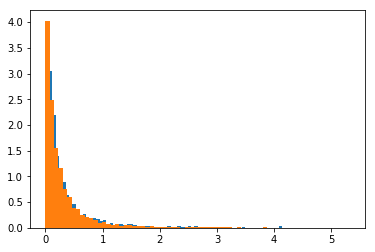

In [65]:
plt.hist(np.array(sample_sents_dif),density=True,bins=70)
plt.hist(np.array(ref_sents_dif),density=True,bins=70)

plt.show()

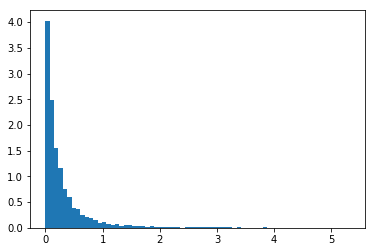

In [64]:
plt.hist(np.array(ref_sents_dif),density=True,bins=70)
plt.show()

In [ ]:
for epoch in range(1, 10):
    # Train
    iterator.restart_dataset(sess, ['train_g'])
    _train_epoch(sess, epoch)

    # Val
    iterator.restart_dataset(sess, 'val')
    _eval_epoch(sess, epoch, 'val')

    #saver.save(sess, os.path.join(config.checkpoint_path, 'ckpt'), epoch)
    saver.save(sess, os.path.join('screensave', 'model'), epoch)

    # Test
    iterator.restart_dataset(sess, 'test')
    _eval_epoch(sess, gamma_, lambda_g_, epoch, 'test')

## female model and male model

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from itertools import chain
from torchtext import data

In [22]:
mTEXT = data.Field(tokenize='spacy')
mLABEL = data.LabelField(tensor_type=torch.FloatTensor)

print("loading dataset male_sent_obftrain_less700.tsv...")
mtrain  = data.TabularDataset.splits(
        path='../../../sent/ori_gender_data/', 
        train='male_sent_obftrain_less700.tsv',
        format='tsv',
        fields=[('Text', mTEXT),('Label', mLABEL)])[0]

print("creating vocab for mTEXT")
mTEXT.build_vocab(mtrain, max_size=60000, vectors="glove.6B.100d")
mLABEL.build_vocab(mtrain)

mLABEL.vocab.stoi['1']=1
mLABEL.vocab.stoi['2']=2
mLABEL.vocab.stoi['3']=3
mLABEL.vocab.stoi['4']=4
mLABEL.vocab.stoi['5']=5

loading dataset male_sent_obftrain_less700.tsv...
creating vocab for mTEXT


In [ ]:
fTEXT = data.Field(tokenize='spacy')
fLABEL = data.LabelField(tensor_type=torch.FloatTensor)

print("loading dataset female_sent_obftrain_less700.tsv...")
ftrain  = data.TabularDataset.splits(
        path='../../../sent/ori_gender_data/', 
        train='female_sent_obftrain_less700.tsv',
        format='tsv',
        fields=[('Text', fTEXT),('Label', fLABEL)])[0]

print("creating vocab for fTEXT")
fTEXT.build_vocab(ftrain, max_size=60000, vectors="glove.6B.100d")
fLABEL.build_vocab(ftrain)

fLABEL.vocab.stoi['1']=1
fLABEL.vocab.stoi['2']=2
fLABEL.vocab.stoi['3']=3
fLABEL.vocab.stoi['4']=4
fLABEL.vocab.stoi['5']=5

loading dataset female_sent_obftrain_less700.tsv...


In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):       
        embedded = self.dropout(self.embedding(x))
        output, (hidden, cell) = self.rnn(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))        
        y = self.fc(hidden.squeeze(0))
        return y


criterion = nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
criterion = criterion.to(device)


#frnn = torch.load('frnn8', map_location=lambda storage, loc: storage) #force to load on CPU
#mrnn = torch.load('mrnn8', map_location=lambda storage, loc: storage) #force to load on CPU
print("loading frnn model and mrnn model....")
frnn = torch.load('../../../sent_analysis/frnn8')
mrnn = torch.load('../../../sent_analysis/mrnn8')
mrnn = mrnn.to(device)
frnn = frnn.to(device)
criterion = criterion.to(device)


import spacy
nlp = spacy.load('en')
def predict_sentiment(sentence,model,TEXT):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    model.eval()
    prediction = model(tensor)
    return prediction.item()


def predict_word(word):
    print('frnn: ',predict_sentiment(word,frnn,fTEXT))
    print('mrnn:  ',predict_sentiment(word,mrnn,mTEXT))

In [ ]:
def pre_dif(s):
    return np.abs(predict_sentiment(s,mrnn,mTEXT)-predict_sentiment(s,frnn,fTEXT))